# Data Analytics Project - Models

# Pair 3 - TATAMOTORS Linear Regression Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 3 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair3/Pair3_orders.csv')
orders_df.head()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
0,2018-01-08,433.549988,177.449997,256.099991,1.441892,FLAT
1,2018-01-09,437.549988,174.800003,262.749985,1.987008,SHORT
2,2018-01-10,433.299988,171.399994,261.899994,1.917332,SHORT
3,2018-01-11,434.750000,175.149994,259.600006,1.728797,SHORT
4,2018-01-12,437.100006,174.050003,263.050003,2.011601,SHORT


In [3]:
orders_df.tail()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
55,2018-04-02,339.149994,114.199997,224.949997,-1.111545,FLAT
56,2018-04-03,343.100006,118.349998,224.750008,-1.127938,FLAT
57,2018-04-04,355.600006,114.849998,240.750008,0.183619,GET_OUT_OF_POSITION
58,2018-04-05,362.200012,116.900002,245.300011,0.556593,FLAT
59,2018-04-06,364.100006,119.599998,244.500008,0.491015,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

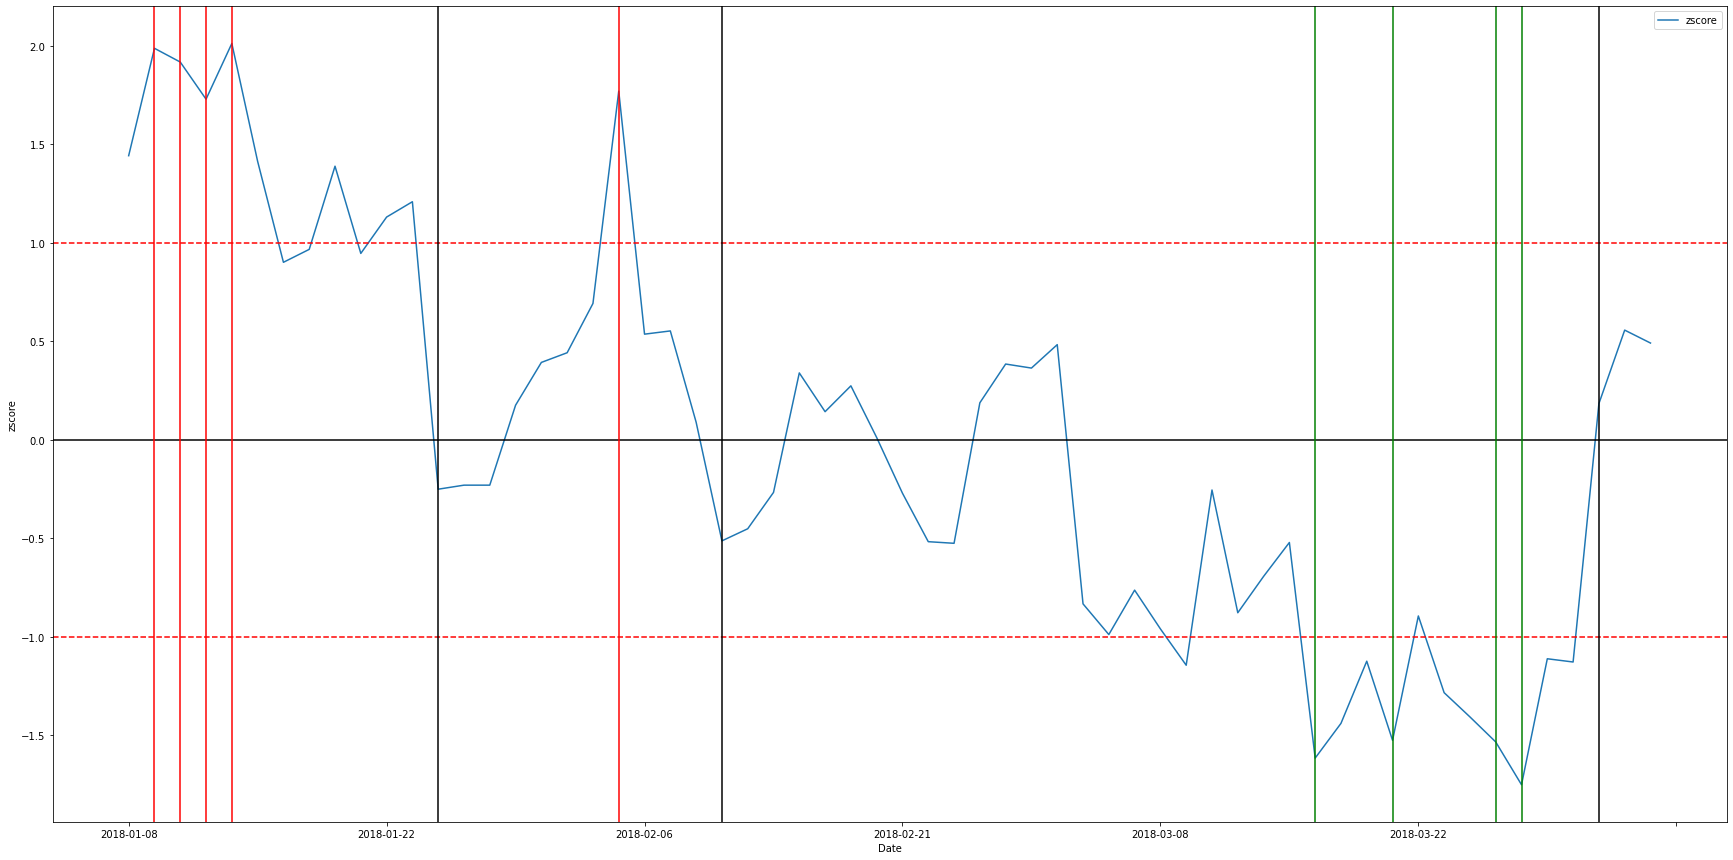

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

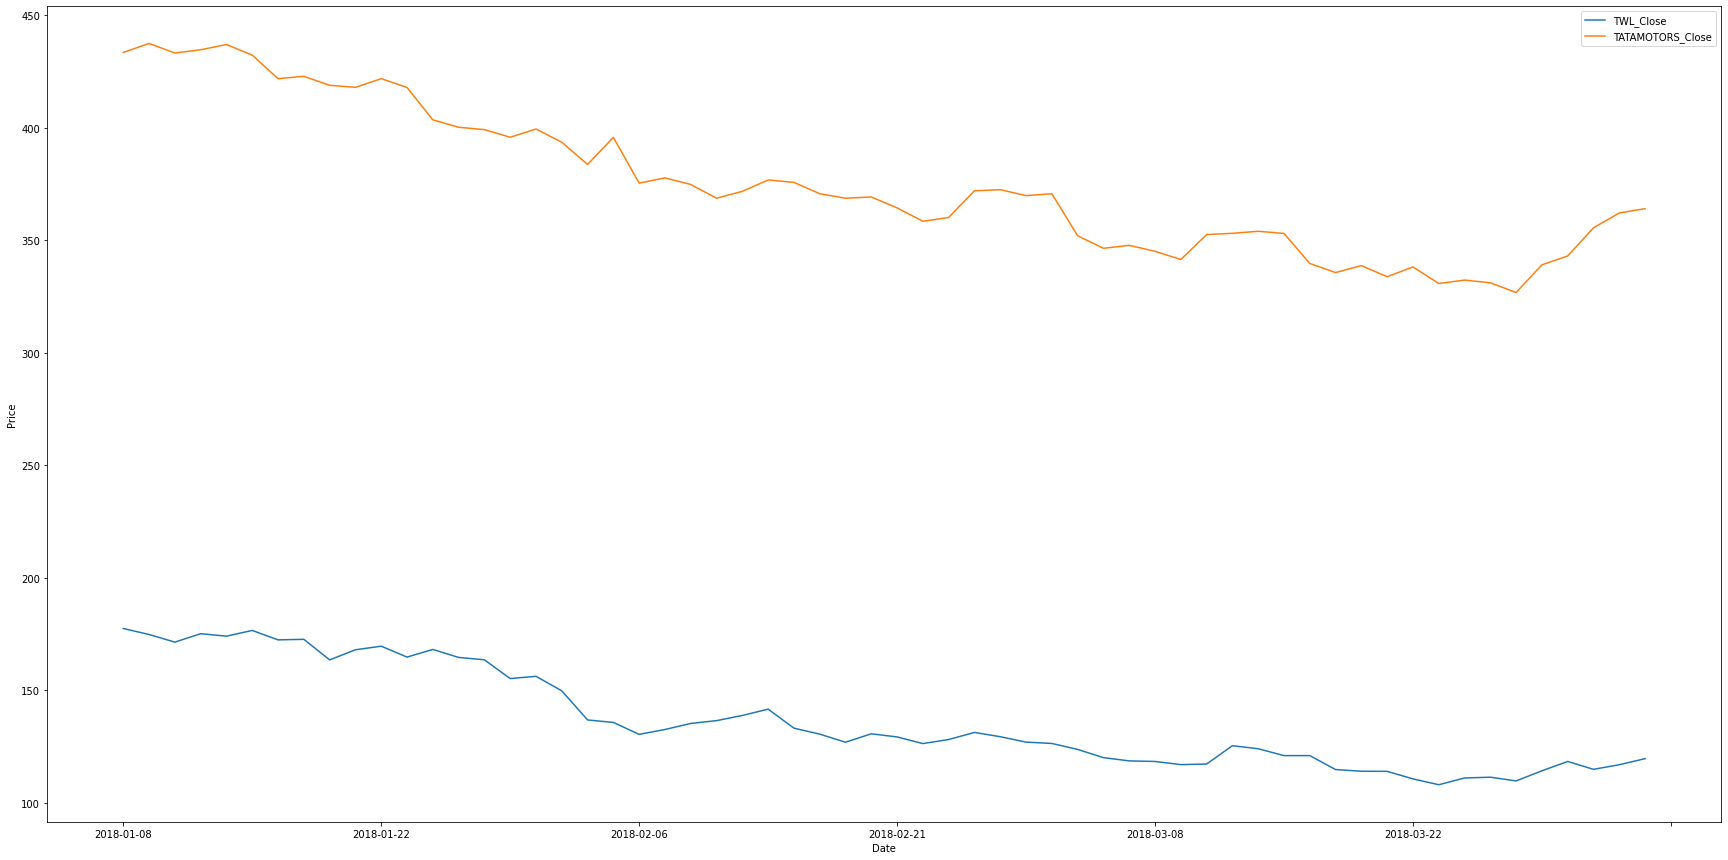

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['TWL_Close', 'TATAMOTORS_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. TATAMOTORS Linear Regression Model

## 3.1. Get the Complete TATAMOTORS dataset

In [6]:
tata_df = pd.read_csv("../../Storage/Companies_with_names_exchange/TATAMOTORSNSE.csv")
tata_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,488.700012,469.049988,472.000000,487.049988,4024156.0,487.049988,TATAMOTORS,NSE
1,2017-01-03,492.700012,479.899994,491.000000,481.100006,5814518.0,481.100006,TATAMOTORS,NSE
2,2017-01-04,493.700012,484.100006,484.649994,486.649994,4769872.0,486.649994,TATAMOTORS,NSE
3,2017-01-05,503.399994,495.549988,496.000000,502.149994,7961242.0,502.149994,TATAMOTORS,NSE
4,2017-01-06,507.950012,496.250000,502.950012,497.750000,4907475.0,497.750000,TATAMOTORS,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get TATAMOTORS training data

### 3.2.1 Get complete tata dataset

In [7]:
tata_df = tata_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
tata_df.head()

,Date,Close
0,2017-01-02,487.049988
1,2017-01-03,481.100006
2,2017-01-04,486.649994
3,2017-01-05,502.149994
4,2017-01-06,497.750000


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
tata_df_train = tata_df[tata_df['Date'] >= '2017-09-03']
tata_df_train.head()

,Date,Close
166,2017-09-04,383.399994
167,2017-09-05,388.149994
168,2017-09-06,382.700012
169,2017-09-07,378.149994
170,2017-09-08,375.049988


In [9]:
tata_df_train = tata_df_train[tata_df_train['Date'] <= '2018-09-04']
tata_df_train.tail()

,Date,Close
412,2018-08-29,261.700012
413,2018-08-30,259.350006
414,2018-08-31,267.500000
415,2018-09-03,266.600006
416,2018-09-04,261.950012


### 3.2.3 Add extra date columns to the training data

In [10]:
add_datepart(tata_df_train, 'Date')

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
166,383.399994,2017,36,9,4,0,247,False,False,False,False,False,False,1504483200
167,388.149994,2017,36,9,5,1,248,False,False,False,False,False,False,1504569600
168,382.700012,2017,36,9,6,2,249,False,False,False,False,False,False,1504656000
169,378.149994,2017,36,9,7,3,250,False,False,False,False,False,False,1504742400
170,375.049988,2017,36,9,8,4,251,False,False,False,False,False,False,1504828800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,261.700012,2018,35,8,29,2,241,False,False,False,False,False,False,1535500800
413,259.350006,2018,35,8,30,3,242,False,False,False,False,False,False,1535587200
414,267.500000,2018,35,8,31,4,243,True,False,False,False,False,False,1535673600
415,266.600006,2018,36,9,3,0,246,False,False,False,False,False,False,1535932800


### 3.2.4 Get the training data and labels

In [11]:
tata_train_X = tata_df_train.copy()

In [12]:
tata_train_X = tata_train_X.reset_index(drop=True)
tata_train_X_plot = tata_train_X.copy()
tata_train_X = tata_train_X.drop(columns=["Elapsed", "Close"])
tata_train_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2017,36,9,4,0,247,False,False,False,False,False,False
1,2017,36,9,5,1,248,False,False,False,False,False,False
2,2017,36,9,6,2,249,False,False,False,False,False,False
3,2017,36,9,7,3,250,False,False,False,False,False,False
4,2017,36,9,8,4,251,False,False,False,False,False,False


In [13]:
tata_train_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
246,2018,35,8,29,2,241,False,False,False,False,False,False
247,2018,35,8,30,3,242,False,False,False,False,False,False
248,2018,35,8,31,4,243,True,False,False,False,False,False
249,2018,36,9,3,0,246,False,False,False,False,False,False
250,2018,36,9,4,1,247,False,False,False,False,False,False


In [14]:
tata_train_y = tata_df[(tata_df['Date'] >= '2017-09-04') & (tata_df['Date'] <= '2018-09-04')]['Close']
tata_train_y

166    383.399994
167    388.149994
168    382.700012
169    378.149994
170    375.049988
          ...    
412    261.700012
413    259.350006
414    267.500000
415    266.600006
416    261.950012
Name: Close, Length: 251, dtype: float64

In [15]:
len(tata_train_X)

251

In [16]:
len(tata_train_y)

251

## 3.3. Get TATAMOTORS Test Data

In [17]:
tata_test_df = orders_df.copy()
tata_test_df = tata_df[(tata_df['Date'] >= '2018-09-04') & (tata_df['Date'] <= '2018-12-03')].copy()
tata_test_df.head()

,Date,Close
416,2018-09-04,261.950012
417,2018-09-05,266.500000
418,2018-09-06,269.950012
419,2018-09-07,277.399994
420,2018-09-10,275.700012


In [18]:
tata_test_df.tail()

,Date,Close
470,2018-11-27,180.050003
471,2018-11-28,174.449997
472,2018-11-29,177.250000
473,2018-11-30,171.949997
474,2018-12-03,175.449997


In [19]:
add_datepart(tata_test_df, 'Date')
tata_test_df.head()

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
416,261.950012,2018,36,9,4,1,247,False,False,False,False,False,False,1536019200
417,266.500000,2018,36,9,5,2,248,False,False,False,False,False,False,1536105600
418,269.950012,2018,36,9,6,3,249,False,False,False,False,False,False,1536192000
419,277.399994,2018,36,9,7,4,250,False,False,False,False,False,False,1536278400
420,275.700012,2018,37,9,10,0,253,False,False,False,False,False,False,1536537600


In [20]:
tata_test_X = tata_test_df.copy()
tata_test_X = tata_test_X.drop(columns=['Close', "Elapsed"])
tata_test_X.reset_index(drop=True, inplace=True)
tata_test_X.index += 251
tata_test_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
251,2018,36,9,4,1,247,False,False,False,False,False,False
252,2018,36,9,5,2,248,False,False,False,False,False,False
253,2018,36,9,6,3,249,False,False,False,False,False,False
254,2018,36,9,7,4,250,False,False,False,False,False,False
255,2018,37,9,10,0,253,False,False,False,False,False,False


In [21]:
tata_test_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
305,2018,48,11,27,1,331,False,False,False,False,False,False
306,2018,48,11,28,2,332,False,False,False,False,False,False
307,2018,48,11,29,3,333,False,False,False,False,False,False
308,2018,48,11,30,4,334,True,False,False,False,False,False
309,2018,49,12,3,0,337,False,False,False,False,False,False


In [22]:
tata_test_y = tata_df[(tata_df['Date'] >= '2018-09-04') & (tata_df['Date'] <= '2018-12-03')]
tata_test_y.reset_index(drop=True, inplace=True)
tata_test_y.index += 251
tata_test_y = tata_test_y['Close']

In [23]:
tata_test_y

251    261.950012
252    266.500000
253    269.950012
254    277.399994
255    275.700012
256    267.299988
257    262.399994
258    266.600006
259    260.250000
260    251.500000
261    252.600006
262    250.350006
263    240.199997
264    240.800003
265    233.350006
266    225.250000
267    223.699997
268    229.350006
269    227.600006
270    223.250000
271    216.250000
272    212.350006
273    184.350006
274    188.750000
275    182.949997
276    183.750000
277    184.350006
278    185.850006
279    179.949997
280    174.699997
281    170.750000
282    170.649994
283    170.649994
284    165.350006
285    168.500000
286    175.350006
287    177.250000
288    179.100006
289    179.449997
290    190.300003
291    189.800003
292    193.250000
293    194.850006
294    195.250000
295    186.050003
296    179.500000
297    176.800003
298    180.199997
299    179.899994
300    184.600006
301    183.750000
302    184.149994
303    182.550003
304    181.750000
305    180.050003
306    174

In [24]:
len(tata_test_X)

59

In [25]:
len(tata_test_y)

59

## 3.4 Create and Train TATAMOTORS Model

In [26]:
model = LinearRegression()
model = model.fit(tata_train_X, tata_train_y)

## 3.5. Get predictions

In [27]:
predictions = model.predict(tata_test_X)
predictions_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df.index += 251
predictions_df

,predictions
251,259.002342
252,258.402641
253,257.802941
254,257.203241
255,255.744917
256,255.145217
257,254.545517
258,253.346116
259,251.887793
260,251.288092


In [28]:
predictions_df['test_data'] = tata_test_y
predictions_df

,predictions,test_data
251,259.002342,261.950012
252,258.402641,266.500000
253,257.802941,269.950012
254,257.203241,277.399994
255,255.744917,275.700012
256,255.145217,267.299988
257,254.545517,262.399994
258,253.346116,266.600006
259,251.887793,260.250000
260,251.288092,251.500000


In [29]:
predictions = predictions_df['predictions']
predictions

251    259.002342
252    258.402641
253    257.802941
254    257.203241
255    255.744917
256    255.145217
257    254.545517
258    253.346116
259    251.887793
260    251.288092
261    250.688392
262    249.488991
263    248.030668
264    247.430967
265    246.831267
266    246.231567
267    245.631866
268    247.706085
269    237.194816
270    236.595116
271    235.995416
272    234.537092
273    233.937392
274    233.337692
275    232.737991
276    232.138291
277    230.679968
278    230.080267
279    229.480567
280    228.281166
281    226.822843
282    226.223142
283    225.623442
284    225.023742
285    224.424041
286    222.965718
287    222.366018
288    224.037395
289    228.397190
290    225.787512
291    224.329188
292    223.729488
293    223.129788
294    221.930387
295    220.472064
296    219.872363
297    219.272663
298    218.672963
299    218.073262
300    216.614939
301    216.015239
302    215.415538
303    214.815838
304    212.757814
305    212.158114
306    211

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(tata_test_y, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(tata_test_y, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(tata_test_y, predictions)))
print('R2 Score:', metrics.r2_score(tata_test_y, predictions))

Mean Absolute Error: 30.446800902809446
Mean Squared Error: 1203.3789588662362
Root Mean Squared Error: 34.68975293752084
R2 Score: 0.007458451461758497


## 3.6. Visualize the predicitons vs test data

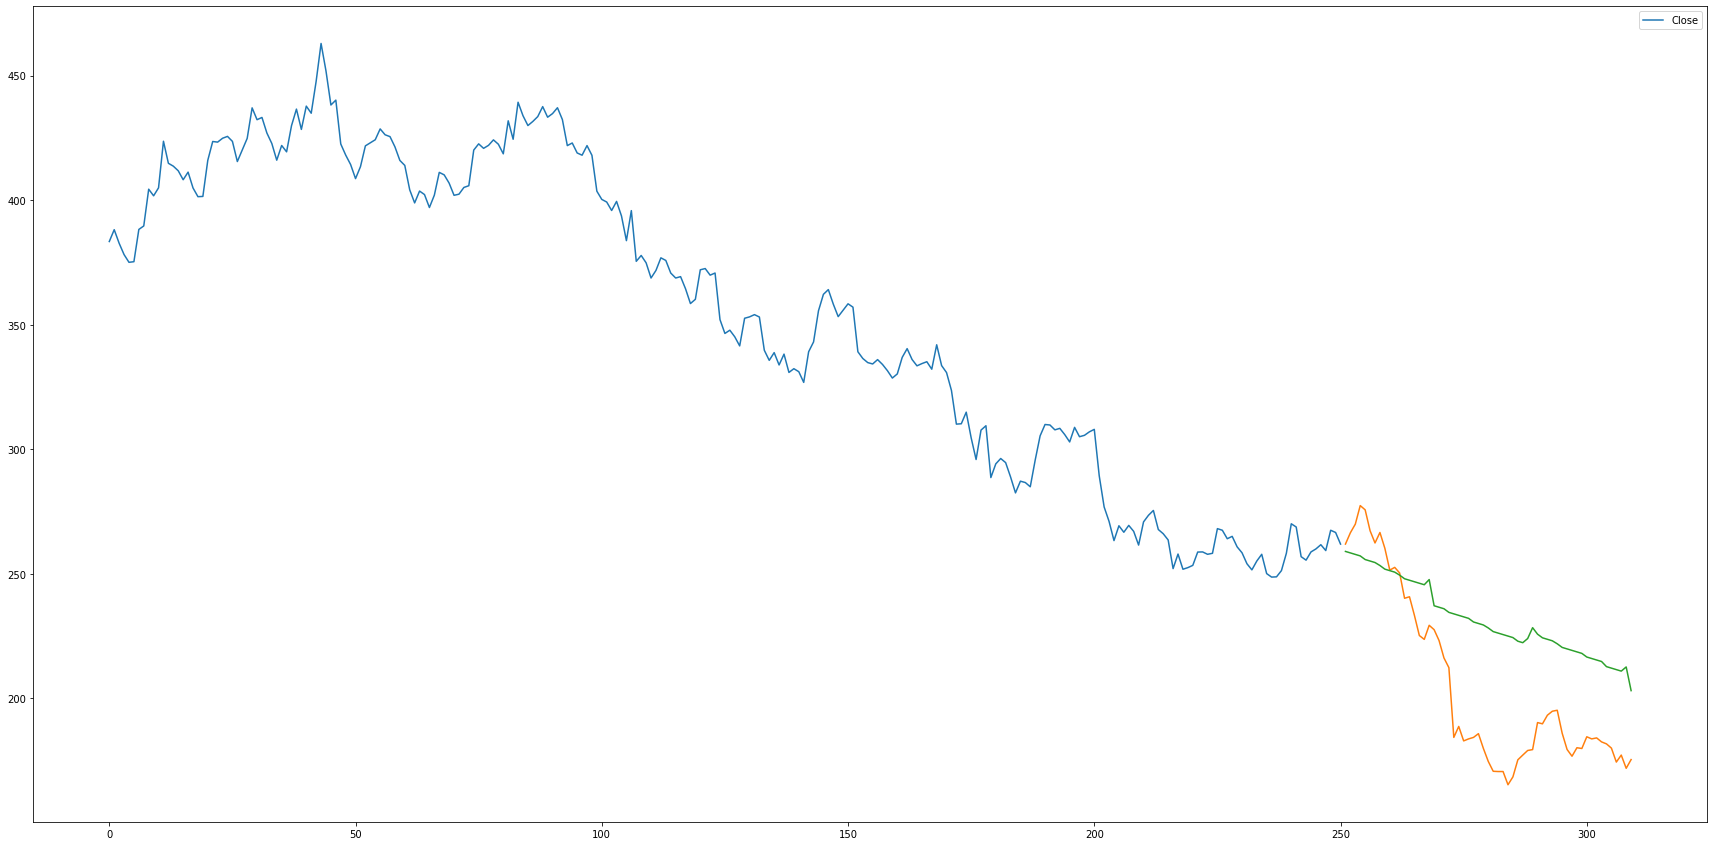

In [31]:
tata_model_plt = tata_train_X_plot.plot(y=['Close'], figsize=(30,15))
tata_model_plt.plot(predictions_df['test_data'])
tata_model_plt.plot(predictions_df['predictions'])

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results into a file

In [32]:
tata_predictions_data = {'Date': orders_df['Date'], 'Actual_Close': orders_df['TATAMOTORS_Close']}
tata_predictions_df = pd.DataFrame(tata_predictions_data)
tata_predictions_df.head()

,Date,Actual_Close
0,2018-01-08,433.549988
1,2018-01-09,437.549988
2,2018-01-10,433.299988
3,2018-01-11,434.750000
4,2018-01-12,437.100006


In [33]:
predictions_df = predictions_df.reset_index()
tata_predictions_df['Linear_regression_Close'] = predictions_df['predictions']
tata_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2018-01-08,433.549988,259.002342
1,2018-01-09,437.549988,258.402641
2,2018-01-10,433.299988,257.802941
3,2018-01-11,434.750000,257.203241
4,2018-01-12,437.100006,255.744917


In [34]:
tata_predictions_df.to_csv('Tata_predicitions.csv', index=False)